In [27]:
import psycopg2
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy import interpolate

import os
from dotenv import load_dotenv

load_dotenv()

database = "speed_data"
password = os.getenv("DB_PASSWORD")
user = os.getenv("DB_USER")


In [32]:
class ConnectDB():
    def __init__(self, database, user, password, host = "127.0.0.1", port = "5432"):
        self.__database = database
        self.__user = user
        self.__password = password
        self.__host = host
        self.__port = port

    def __enter__(self):
        self.__conn = psycopg2.connect(
            database = self.__database,
            user = self.__user,
            password = self.__password,
            host = self.__host,
            port = self.__port,
        )
        self.__conn.autocommit = True
        self.__cursor = self.__conn.cursor()
        return self
    
    def __exit__(self, type, value, traceback):
        self.__cursor.close()
        self.__conn.close()

    def execute(self, query, vars = None):
        self.__cursor.execute(query, vars)
    
    def select(self, query, vars = None):
        self.__cursor.execute(query, vars)
        return self.__cursor.fetchall()
    
    def get_data_speed(self, id):
        self.__cursor.execute(f"select timestamp, speed from messages where terminal_id='{id}' limit 1000") # 433427026902662
        return [dict((self.__cursor.description[i][0], value) for i, value in enumerate(row)) for row in self.__cursor.fetchall()]
    
    def get_data_can(self, id):
        self.__cursor.execute(f"select timestamp, can_data, speed from messages where terminal_id='{id}'") # 433100526928099 433019520494099
        return [dict((self.__cursor.description[i][0], value) for i, value in enumerate(row)) for row in self.__cursor.fetchall()]

## Задание 1 (сделано ранее)
- Получить данные из бд (can_data, timestamp)  
- Перевести timestamp в нормальный вид  
- Отсортировать данные по возрастанию (timestamp)  
- Построить график по данным  

## Задание 2
- Получить данные из бд (can_data, timestamp)
- Перевести timestamp в нормальный вид
- Перевести данные из can_data в литры
- Отсортировать данные по возрастанию (timestamp)
- Построить график по данным

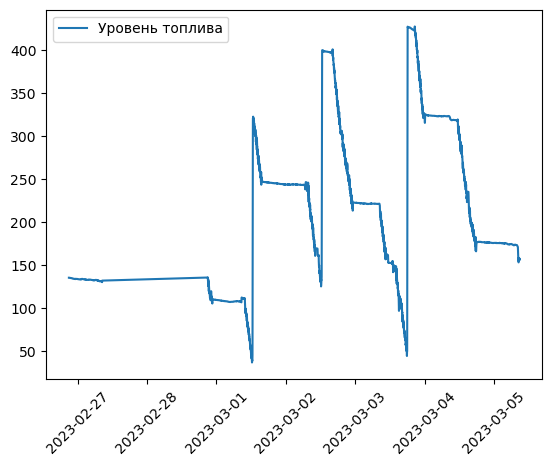

In [33]:
with ConnectDB(database = database, user = user, password = password) as connect:
    x, y = [], []
    for i in connect.select("select calibrating_data from calibrating where deviceid_port like '433100526928099_%'")[0][0]: # Данные для калибровки
        x.append(i["input_value"])
        y.append(i["output_value"])

    f = interpolate.interp1d(x, y)

    x, y, speed = [], [], []
    for i in connect.get_data_can(433100526928099): # Данные для отрисовки графика
        x.append(i["timestamp"])
        y.append(i["can_data"]["LLS_0"])
        speed.append(i["speed"])

    y = f(y)


    x, y = np.array(x), np.array(y, dtype = float)
    x_order = x.argsort()
    x, y = x[x_order], y[x_order]

    x = np.array(x, dtype = np.datetime64)

    plt.plot(x, y, label = "Уровень топлива")

    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()

## Задание 3
- Получить данные из бд (can_data, timestamp)
- Перевести данные из can_data в литры
- Отсортировать данные по возрастанию (timestamp)
- Построить график по данным
- Провести сглаживание данных
- Построить график по сглаженным данным

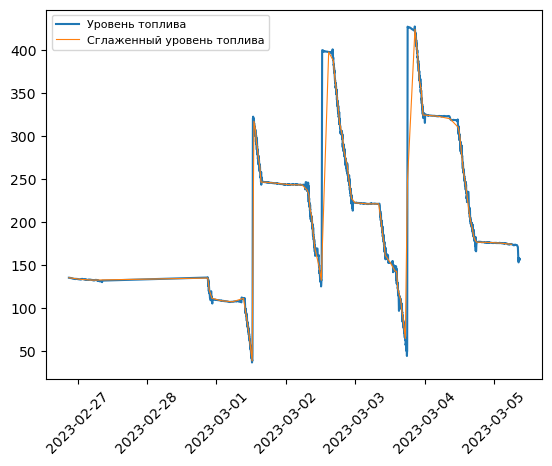

In [34]:
with ConnectDB(database = database, user = user, password = password) as connect:
    x, y = [], []
    for i in connect.select("select calibrating_data from calibrating where deviceid_port like '433100526928099_%'")[0][0]: # Данные для калибровки
        x.append(i["input_value"])
        y.append(i["output_value"])

    f = interpolate.interp1d(x, y)

    x, y, speed = [], [], []
    for i in connect.get_data_can(433100526928099): # Данные для отрисовки графика
        x.append(i["timestamp"])
        y.append(i["can_data"]["LLS_0"])
        speed.append(i["speed"])

    y = f(y)


    x, y = np.array(x), np.array(y, dtype = float)
    x_order = x.argsort()
    x, y = x[x_order], y[x_order]

    m = np.zeros_like(x, dtype=bool) # Из 19тыс данных примерно 11 - дубликаты по временной метке
    m[np.unique(x, return_index=True)[1]] = True
    x, y = x[m], y[m]

    f = interpolate.interp1d(x, y, kind = "quadratic")
    new_x = x.copy()[::100]
    new_y = f(new_x) 

    x = np.array(x, dtype = np.datetime64) # Интерполяция работает только с числами (с datetime не работает)
    new_x = np.array(new_x, dtype = np.datetime64) # Интерполяция работает только с числами (с datetime не работает)

    plt.plot(x, y, label = "Уровень топлива")
    plt.plot(new_x, new_y, label = "Сглаженный уровень топлива", linewidth = 0.8)

    plt.xticks(rotation = 45)
    plt.legend(prop = {"size": 8})
    plt.show()

## Задание 4
- Получить данные из бд (can_data, timestamp)
- Перевести timestamp в нормальный вид
- Перевести данные из can_data в литры
- Отсортировать данные по возрастанию (timestamp)
- Построить график по данным
- Реализовать алгоритм заправок

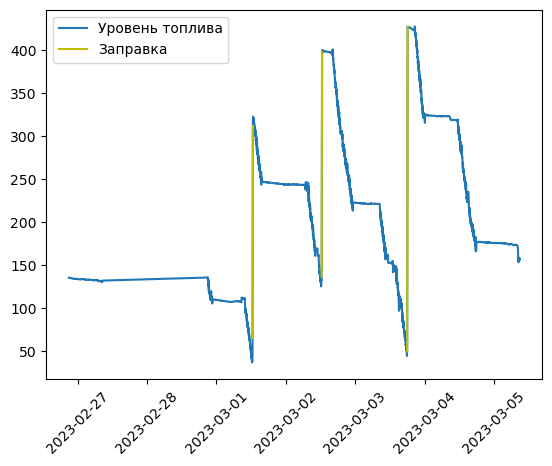

In [35]:
with ConnectDB(database = database, user = user, password = password) as connect:
    x, y = [], []
    for i in connect.select("select calibrating_data from calibrating where deviceid_port like '433100526928099_%'")[0][0]: # Данные для калибровки
        x.append(i["input_value"])
        y.append(i["output_value"])

    f = interpolate.interp1d(x, y)

    x, y, speed = [], [], []
    for i in connect.get_data_can(433100526928099): # Данные для отрисовки графика
        x.append(i["timestamp"])
        y.append(i["can_data"]["LLS_0"])
        speed.append(i["speed"])

    y = f(y)


    x, y = np.array(x), np.array(y, dtype = float)
    x_order = x.argsort()
    x, y = x[x_order], y[x_order]

    m = np.zeros_like(x, dtype=bool) # Из 19тыс данных примерно 11 - дубликаты по временной метке
    m[np.unique(x, return_index=True)[1]] = True
    x, y = x[m], y[m]

    diff = y[1:] - y[:-1]
    mask = np.full(x.size - 1, False)
    for i in range(len(diff)):
        if diff[i] > 20:
            mask[i] = True
            mask[i - 1] = True
            mask[i + 1] = True

    x = np.array(x, dtype = np.datetime64) # Интерполяция работает только с числами (с datetime не работает)

    masked_x = x.copy()[1:]
    masked_x[~mask] = np.datetime64("NaT") # Для разрыва в функциях

    plt.plot(x, y, label = "Уровень топлива")
    plt.plot(masked_x, y[1:], color = "y", label = "Заправка")

    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()

## Задание 5
- Получить данные из бд (can_data, timestamp)
- Перевести timestamp в нормальный вид
- Перевести данные из can_data в литры
- Отсортировать данные по возрастанию (timestamp)
- Построить график по данным
- Реализовать алгоритм заправок
- Реализовать алгоритм сливов

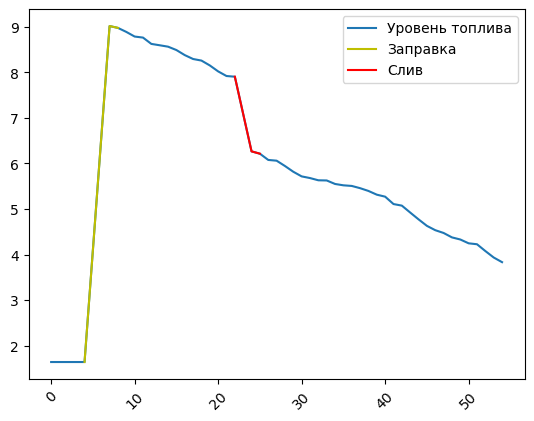

In [44]:
with ConnectDB(database = database, user = user, password = password) as connect:
    x, y = [], []
    for i in connect.select("select calibrating_data from calibrating where deviceid_port like '433100526928099_%'")[0][0]: # Данные для калибровки
        x.append(i["input_value"])
        y.append(i["output_value"])

    f = interpolate.interp1d(x, y)

    x, y, speed = [], [], []
    for i in connect.get_data_can(123456789): # Данные для отрисовки графика
        x.append(i["timestamp"])
        y.append(i["can_data"]["LLS"])
        speed.append(i["speed"])

    y = f(y)


    x, y = np.array(x, dtype = np.float32), np.array(y, dtype = float)
    x_order = x.argsort()
    x, y = x[x_order], y[x_order]

    m = np.zeros_like(x, dtype=bool) # Из 19тыс данных примерно 11 - дубликаты по временной метке
    m[np.unique(x, return_index=True)[1]] = True
    x, y = x[m], y[m]

    diff = y[1:] - y[:-1]
    mask1 = np.full(x.size - 1, False)
    mask2 = np.full(x.size - 1, False)

    for i in range(len(diff) - 1):
        if diff[i] > 1:
            mask1[i] = True
            mask1[i - 1] = True
            mask1[i + 1] = True
        elif diff[i] < -0.5:
            mask2[i] = True
            mask2[i - 1] = True
            mask2[i + 1] = True

    # x = np.array(x, dtype = np.datetime64) # Интерполяция работает только с числами (с datetime не работает)

    masked_x1 = x.copy()[1:]
    masked_x1[~mask1] = np.nan # Для разрыва в функциях
    masked_x2 = x.copy()[1:]
    masked_x2[~mask2] = np.nan # Для разрыва в функциях

    plt.plot(x, y, label = "Уровень топлива")
    plt.plot(masked_x1, y[1:], color = "y", label = "Заправка")
    plt.plot(masked_x2, y[1:], color = "r", label = "Слив")

    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()